In [24]:
import matplotlib.pyplot as plt
import numpy as np
from open_ephys.analysis import Session
import os
import re
from scipy.signal import butter, filtfilt, lfilter
from collections import defaultdict
import scipy.stats as stats


In [9]:
def scan_experiment_structure(session_dir, record_node_name="Record Node 106"):
    node_path = os.path.join(session_dir, record_node_name)

    if not os.path.exists(node_path):
        print(f"Record Node directory not found: {node_path}")
        return {}

    experiment_info = defaultdict(list)

    for item in sorted(os.listdir(node_path)):
        exp_path = os.path.join(node_path, item)
        if os.path.isdir(exp_path) and item.startswith("experiment"):
            recordings = [
                r for r in sorted(os.listdir(exp_path))
                if os.path.isdir(os.path.join(exp_path, r)) and r.startswith("recording")
            ]
            experiment_info[item] = recordings

    return experiment_info


In [96]:
# ==== Select record node ====
# w = 0 → Record Node 106
# w = 1 → Record Node 111
w = 1

directory = "dEMG_Pilot-0012025-10-31_13-23-53_001"

session = Session(directory)
print("Session loaded successfully.\n")
print(session)


Session loaded successfully.


Open Ephys Recording Session Object
Directory: dEMG_Pilot-0012025-10-31_13-23-53_001

<object>.recordnodes:
  Index 0: Record Node 106 (binary format)
  Index 1: Record Node 111 (binary format)



In [86]:
# === Flatten experiment-recording pairs to loop ===
#flat_recordings = []
#for exp_name, rec_list in structure.items():
#    for rec in rec_list:
#        flat_recordings.append((exp_name, rec))

In [87]:
record_node_name = "Record Node 106" if w == 0 else "Record Node 111"

structure = scan_experiment_structure(directory, record_node_name)
structure


defaultdict(list, {'experiment1': ['recording1', 'recording2', 'recording3']})

In [88]:
recording_index = 2   # choose which recording to load

try:
    recording = session.recordnodes[w].recordings[recording_index]
    print("Loaded:", recording)
except IndexError:
    print(f"Recording index {recording_index} not found.")



directory_str = recording.directory  # full directory path as a string

print("\n\n\n")

print(directory_str)


parts = directory_str.split(os.sep)

# Extract components based on Open Ephys folder structure
record_node_name = parts[-3]   # "Record Node 111"
experiment_name  = parts[-2]   # "experiment1"
recording_name   = parts[-1]   # "recording1"

print(record_node_name)
print(experiment_name)
print(recording_name)



Loaded: Open Ephys GUI Recording
ID: 0x16b02b94e90
Format: Binary
Directory: dEMG_Pilot-0012025-10-31_13-23-53_001\Record Node 106\experiment1\recording3
Experiment Index: 0
Recording Index: 2




dEMG_Pilot-0012025-10-31_13-23-53_001\Record Node 106\experiment1\recording3
Record Node 106
experiment1
recording3


In [89]:
continuous_list = recording.continuous

print(f"Number of continuous streams: {len(continuous_list)}")

stream = continuous_list[0]   # pick first continuous stream
print(stream)

metadata = stream.metadata
channel_names = metadata.channel_names
sample_rate = metadata.sample_rate
num_channels = metadata.num_channels
print("Sample rate:", metadata.sample_rate)
print("Num channels:", metadata.num_channels)
print("Channel names:", metadata.channel_names)


Number of continuous streams: 1
Continuous Data: Acquisition_Board-100.Rhythm Data/ (format='binary', mmap_mode=r)
├─── Samples: 9405691 samples x 5 channels
└─── ContinuousMetadata(source_node_id=100,
                   source_node_name='Acquisition Board',
                   stream_name='Rhythm Data',
                   sample_rate=25000.0,
                   num_channels=5,
                   channel_names=['CH1', 'CH5', 'CH7', 'CH11', 'ADC1'],
                   bit_volts=[0.1949999928474426,
                              0.1949999928474426,
                              0.1949999928474426,
                              0.1949999928474426,
                              0.000152587890625])

Sample rate: 25000.0
Num channels: 5
Channel names: ['CH1', 'CH5', 'CH7', 'CH11', 'ADC1']


In [90]:
# Load continuous data using global timestamps and data shape
timestamps = recording.continuous[0].timestamps
n_timestamps = timestamps.shape[0]
data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=n_timestamps)
print("Data shape:", data.shape)

Data shape: (9405691, 5)


In [91]:
# ==== EMG Processing ====
emg1_raw = data[:, 2]
emg2_raw = data[:, 3]
differential = (emg2_raw - emg1_raw)
lowcut = 100
highcut = 1000

b, a = butter(2, np.array([lowcut, highcut])/(sample_rate/2), btype='bandpass')


#y = lfilter(b, a, x) # only filters in the forward direction


In [92]:

differential_filt = lfilter(b, a, differential)
differential_abs = np.abs(differential_filt)
differential_emg = differential_abs

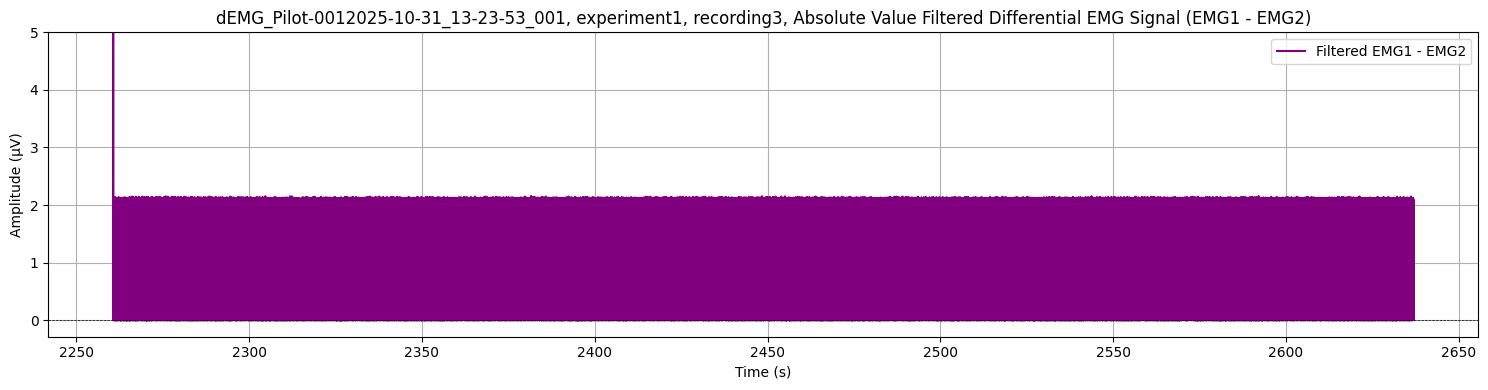

In [95]:
differential_filt = data[:,3] #Only if online filtered

# ==== Full Trace Plot ====
plt.figure(figsize=(15, 4))
plt.plot(timestamps, differential_emg, label="Filtered EMG1 - EMG2", color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.title(f"{directory}, {experiment_name}, {recording_name}, Absolute Value Filtered Differential EMG Signal (EMG1 - EMG2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.grid(True)
plt.legend()
plt.ylim(top=5)
plt.tight_layout()
plt.show()

In [44]:
# ==== Load MessageCenter ====
messagecenter_dir = os.path.join(directory, record_node_name, experiment_name, recording_name, "events", "MessageCenter")
if not os.path.exists(messagecenter_dir):
    print(f"MessageCenter directory not found for {exp_name}/{yy}")
    

texts = np.load(os.path.join(messagecenter_dir, "text.npy"), allow_pickle=True)
timestamps_msg = np.load(os.path.join(messagecenter_dir, "timestamps.npy"))
decoded_texts = [t.decode('utf-8') if isinstance(t, bytes) else str(t) for t in texts]
message_entries = list(zip(timestamps_msg, decoded_texts))
print(f"Loaded {len(decoded_texts)} MessageCenter entries")

# ==== Debug Print ====
for text, time in zip(decoded_texts, timestamps_msg):
    print(f"[Time: {time:.6f} s] Message: {text}")

Loaded 0 MessageCenter entries
